In [97]:
import pandas as pd 
import numpy as np

from sklearn import metrics
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


## 1 - Procedemos a analizar el dataset, revisamos nulos y dropeamos columas que no sean de utilidad

In [44]:
df = pd.read_csv('train.csv')

In [45]:
df.head(4)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000


In [46]:
df.shape

(1460, 81)

In [47]:
print('Total de columnas train:',len(df.columns))
print(f'Registros totales train:',len(df))
print('Columnas de "numéricas":',len(df._get_numeric_data().columns))
df._get_numeric_data().columns

Total de columnas train: 81
Registros totales train: 1460
Columnas de "numéricas": 38


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Veamos como se distribuyen los precios

In [48]:
df['SalePrice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

c:\Users\fhernandezcortez\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


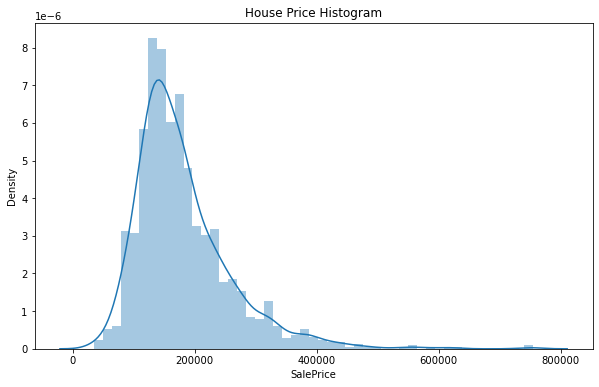

In [49]:
plt.figure(figsize=(10,6))
sns.distplot(df.loc[:, 'SalePrice'],kde=True)
plt.title('House Price Histogram');

La distribucion de los datos no esta normalizada, intentaremos hacerlo posteriormente, procedemos a eliminar columnas que tengan muchos valores nulos

In [50]:
nulos_columnas = df.isnull().sum()
nulos_columnas

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [51]:
nulos_columnas[nulos_columnas > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [52]:
porcentaje_nulos = nulos_columnas[nulos_columnas > 0]/df.shape[0]
porcentaje_nulos

LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64

### Eliminamos columnas cuyo porcentaje de nulos sea mayor a 20%

In [53]:
columnas_a_eliminar=porcentaje_nulos[porcentaje_nulos>0.20].index
columnas_a_eliminar

df.drop(columns = columnas_a_eliminar, inplace = True)

In [54]:
df.shape

(1460, 76)

### Normalizar los datos (o un proceso de normalizacion) y exploracion de Sale Price

In [55]:
#eliminando valores outliers
from scipy import stats
df_SalePrice_Norm = df[np.abs(df.SalePrice-df.SalePrice.mean()) <= (3*df.SalePrice.std())]
df_SalePrice_Norm

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,112,0,0,0,0,4,2010,WD,Normal,142125


In [56]:
#Aplicando raiz cuadrada a toda la columna

df.SalePriceAdjusted = df.SalePrice.apply(np.sqrt)

C:\Users\fhernandezcortez\AppData\Local\Temp\ipykernel_14628\3121383701.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.SalePriceAdjusted = df.SalePrice.apply(np.sqrt)


0       456.618002
1       426.028168
2       472.757866
3       374.165739
4       500.000000
           ...    
1455    418.330013
1456    458.257569
1457    516.236380
1458    376.994695
1459    384.057287
Name: SalePrice, Length: 1460, dtype: float64

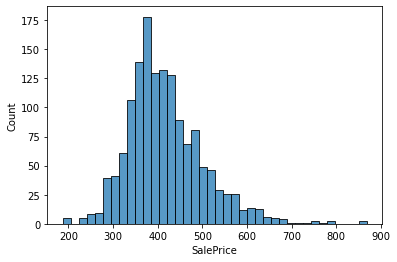

In [57]:
sns.histplot(df.SalePriceAdjusted)
df.SalePriceAdjusted

### Con los datos normalizados, procedemos a analizar qué influye SalePrice y cuales serían las variables más correlacionadas

Relacion entre el numero de cuartos y el precio de venta

'aqui estoy realmente entre el violinplot y el scatterplot, pero en general se esperaria que\nhubiera un comportamiento lineal entre el numero de cuartos y el precio, entre mas cuartos, mayor precio'

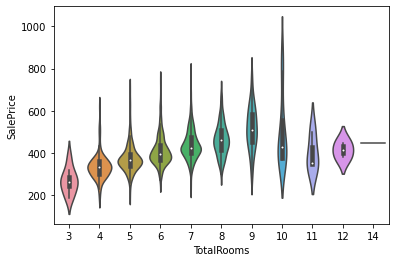

In [58]:
df['TotalRooms'] = df.BedroomAbvGr + df.KitchenAbvGr + df.FullBath + df.HalfBath + df.BsmtFullBath + df.BsmtHalfBath

#sns.scatterplot(x=df.LotArea, y=df.SalePrice)
sns.violinplot(x=df.TotalRooms, y=df.SalePriceAdjusted) 
'''aqui estoy realmente entre el violinplot y el scatterplot, pero en general se esperaria que
hubiera un comportamiento lineal entre el numero de cuartos y el precio, entre mas cuartos, mayor precio'''

Relacion entre el espacio o lot area y el precio de venta

In [59]:
df[['GrLivArea','LotArea','GarageArea']]

'''Para esta parte, no voy a tomar en consideracion gr o garage area, para este calculo solo me va a importar el area del lote, que lo considero como el area total ref https://math.answers.com/geometry/What_is_the_difference_between_floor_area_and_lot_area
 ademas como se puede observar en el df, el lot area es mucho mayor a las demas'''

'Para esta parte, no voy a tomar en consideracion gr o garage area, para este calculo solo me va a importar el area del lote, que lo considero como el area total ref https://math.answers.com/geometry/What_is_the_difference_between_floor_area_and_lot_area\n ademas como se puede observar en el df, el lot area es mucho mayor a las demas'

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

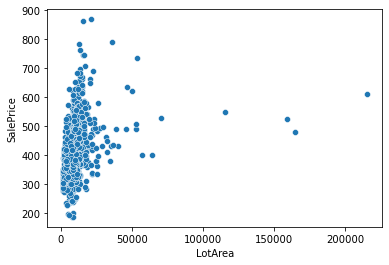

In [60]:
sns.scatterplot(y=df.SalePriceAdjusted, x=df.LotArea)

Relacion entre la edad de la casa y su precio de venta

In [61]:
df['AgeofHouse'] = df.YearBuilt.max() - df['YearBuilt']

df['HouseRemodel'] = df.YearRemodAdd.max() - df['YearRemodAdd']


<AxesSubplot:xlabel='AgeofHouse', ylabel='SalePrice'>

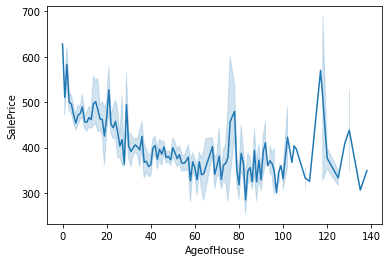

In [62]:
sns.lineplot(x=df.AgeofHouse , y=df.SalePriceAdjusted)

Procedemos con la correlacion de tipo Pearson para ver cuales son las variables que afectan más el precio de venta

<AxesSubplot:>

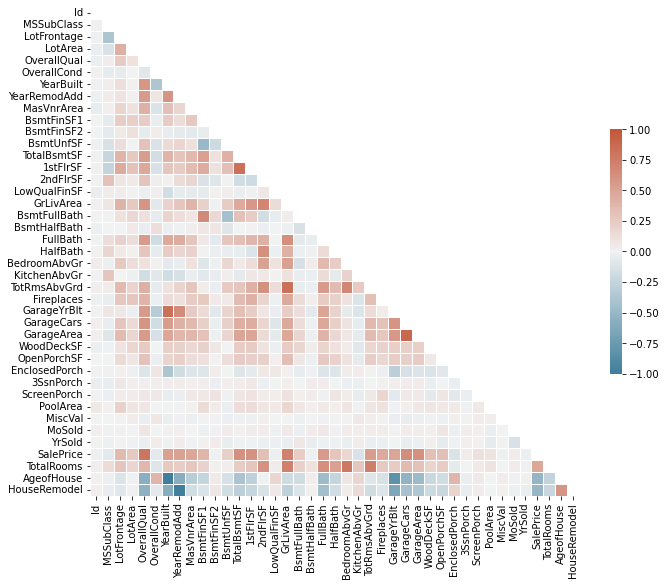

In [63]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Conclusiones de data

La calidad es fundamental para el precio de una vivienda, con base en lo observado de la tabla de correlaciones, es una variable muy relacionada al precio de la vivienda.

In [88]:
corr.loc[corr['OverallQual'] > 0.9] #aqui se puede apreciar que el sale price es 0.8, lo cual demuestra una furte relacion

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,TotalRooms,AgeofHouse,HouseRemodel
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.0,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982,0.371702,-0.572323,-0.550684


Por lo tanto, intentaremos hacer una regresion lineal considerando la calidad vs el precio

In [90]:
slope, intercept, rvalue, pvalue, stderr = linregress(df['SalePrice'], df['OverallQual'])
print(f' Slope: {slope}')
print(f' Intercept: {intercept}')
print(f' Pvalue: {pvalue}')

 Slope: 1.3770019604696928e-05
 Intercept: 3.6080266541769785
 Pvalue: 2.185675268e-313


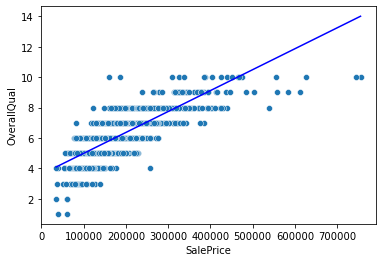

In [94]:
sns.scatterplot(x = df['SalePrice'], y = df['OverallQual'])
x = [df['SalePrice'].min(), df['SalePrice'].max()]
y = [intercept + df['SalePrice'].min() * slope, intercept + df['SalePrice'].max() * slope]
sns.lineplot(x = x, y = y, color = 'b');

In [100]:

x = sm.add_constant(df['OverallQual'])
y = df['SalePrice']

linreg_stats = sm.OLS(y,x).fit()

In [101]:
print(linreg_stats.summary())


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2437.
Date:                Sat, 30 Jul 2022   Prob (F-statistic):          2.19e-313
Time:                        16:02:13   Log-Likelihood:                -17827.
No. Observations:                1460   AIC:                         3.566e+04
Df Residuals:                    1458   BIC:                         3.567e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.621e+04   5756.407    -16.713      

Valor de R2 de 0.6, nos damos por bien servidos para ser una correlacion sencilla. Entre mas calidad, el precio incrementara radicalmente

## 2- Pruebas de hipotesis

Para este caso haremos dos pruebas.

Prueba 1:


H0 = no hay diferencia entre el promedio del precio de una casa con garage vs el precio promedio de todas las casas del df.


H1 = si existe una diferencia entre el precio de casa con garage vs el precio promedio de todas las casas del df.

Prueba 2:


H0 = no hay diferencia entre el promedio del precio de una casa con baño completo vs el precio promedio de todas las casas del df.


H1 = si existe una diferencia entre el precio de casa con baño completo vs el precio promedio de todas las casas del df.

In [80]:
mu = df['SalePrice']
garage = df[(df['SalePrice']) & (df['GarageCars'] > 0)]
full_bath = df[(df['SalePrice']) & (df['FullBath'] > 1)]

print(f'Mean Sales Price of all the houses: {mu.mean()}')
print(f'Mean Sales Price of Houses with Garage: {garage.SalePrice.mean()}')
print(f'Mean Sales Price of Houses with Full_bath: {full_bath.SalePrice.mean()}')

Mean Sales Price of all the houses: 180921.19589041095
Mean Sales Price of Houses with Garage: 248973.21739130435
Mean Sales Price of Houses with Full_bath: 291952.1176470588


Prueba 1

In [86]:
t, p = stats.ttest_1samp(garage.SalePrice, mu)


print(f'El promedio de p value para doto el data set de gara es {p.mean()}')

#en promedio, interesantemente, aceptariamos la hipotesis nula de que el precio del garage no influye el precio de la casa para el dataset

El promedio de p value para doto el data set de gara es 0.0700949909355248


Prueba 2

In [87]:
t, p = stats.ttest_1samp(full_bath.SalePrice, mu)


print(f'El promedio de p value para doto el data set de gara es {p.mean()}')

#en este caso, el p value es menor a 0.05 por lo tanto rechazamos la hipotesis nula, lo cual indica que si existe una diferencia de precio para casas con baños completos

El promedio de p value para doto el data set de gara es 0.04011054594590118


## 3 -Eliminar dimensionalidad con PCA

Como el PCA es otro enfoque para reducción de columnas, empezamos cargando el df desde 0

In [28]:
df = pd.read_csv('train.csv')

In [29]:
#mantenemos solo las columnas numericas del df

df = df.select_dtypes(include=['int64','float'])
df.shape

(1460, 38)

In [30]:
scaler = StandardScaler()
norm_data = scaler.fit_transform(df)

In [31]:
df_norm = pd.DataFrame(norm_data, index = df.index, columns = df.columns).fillna(0).astype('float64')
df_norm.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,-1.730865,0.073375,-0.208034,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273
1,-1.728492,-0.872563,0.409895,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288
2,-1.726120,0.073375,-0.084449,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154
3,-1.723747,0.309859,-0.414011,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281
4,-1.721374,0.073375,0.574676,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843


In [32]:
pca = PCA()
pca.fit(df_norm)

PCA()

In [33]:
pca.explained_variance_ratio_

array([2.07932346e-01, 8.48505599e-02, 6.68767599e-02, 5.34711858e-02,
       3.94844517e-02, 3.15809361e-02, 3.05766385e-02, 3.00101675e-02,
       2.90680039e-02, 2.89143728e-02, 2.83985501e-02, 2.74273845e-02,
       2.68959671e-02, 2.64865879e-02, 2.52785012e-02, 2.38909322e-02,
       2.30434565e-02, 2.18359574e-02, 2.15054194e-02, 2.07579660e-02,
       1.95398871e-02, 1.76925222e-02, 1.64407634e-02, 1.54654462e-02,
       1.34060410e-02, 1.07922531e-02, 1.04940347e-02, 8.48667849e-03,
       7.69280677e-03, 6.95384542e-03, 6.18425396e-03, 5.14192906e-03,
       4.00717971e-03, 3.72075716e-03, 3.22320913e-03, 2.47224806e-03,
       4.10074247e-32, 1.22480985e-33])

Text(0, 0.5, 'Var acumulada explicada')

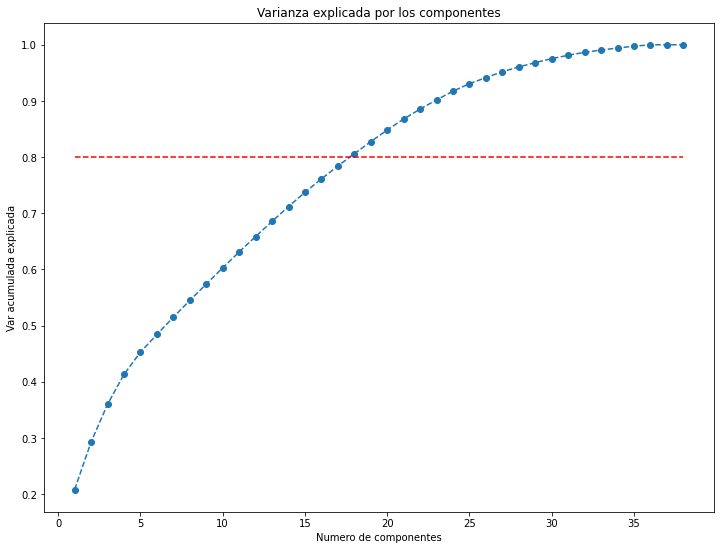

In [34]:
plt.figure(figsize = (12,9))
plt.plot(range(1,pca.n_components_+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.hlines(y=.8 , xmin = 1, xmax= pca.n_components_ , colors = 'red', linestyles= '--')
plt.title('Varianza explicada por los componentes')
plt.xlabel('Numero de componentes')
plt.ylabel('Var acumulada explicada')

### Por el grafico podemos apreciar que el numero de columnas se reduce a 18, por lo tanto, seguimos ajustando:

In [35]:
pca = PCA(n_components = 18)
pca.fit(df_norm)

PCA(n_components=18)

In [36]:
df_transform = pca.transform(df_norm)


In [37]:
cols = ['C' + str(x) for x in range(1,19)]


In [38]:
data_pca = pd.DataFrame(df_transform, index = df_norm.index, columns =cols)
data_pca.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18
0,1.504617,0.376258,-1.647342,-1.976697,0.500511,1.228876,-0.500398,-0.496842,-0.537878,0.118438,-1.218091,0.826352,0.401767,0.275991,0.230684,-1.128816,-1.432628,0.259422
1,-0.017001,-1.106256,1.232414,-0.005895,-1.818108,0.087449,3.753870,-0.157592,0.019902,-0.142189,-0.918202,-1.448262,1.637441,-0.006240,-0.818925,-1.050989,-0.839710,0.537646
2,1.741236,0.247663,-1.440500,-1.413153,-0.168899,-0.265502,-0.065232,-0.407902,-0.579630,0.215300,-0.997202,0.758022,-0.838971,0.614479,0.318852,-0.258082,-0.506961,0.878062
3,-0.496564,1.007974,0.835331,-0.127375,0.347724,0.491240,-1.483594,0.419956,-2.659070,0.527768,-1.028027,-1.864572,-0.393003,1.433627,2.827078,-1.290521,-0.524578,0.194778
4,4.447654,1.129776,-0.514087,-1.364016,-0.059917,-0.641679,0.619821,-0.565955,-0.835903,-0.372470,-0.770402,0.608538,-1.489451,0.604568,0.018934,-0.733559,-0.133184,1.399160


In [39]:
df_pca_comp = pd.DataFrame( data = pca.components_,
                           columns = df_norm.columns.values,
                           index = cols)
df_pca_comp.shape

(18, 38)

<AxesSubplot:>

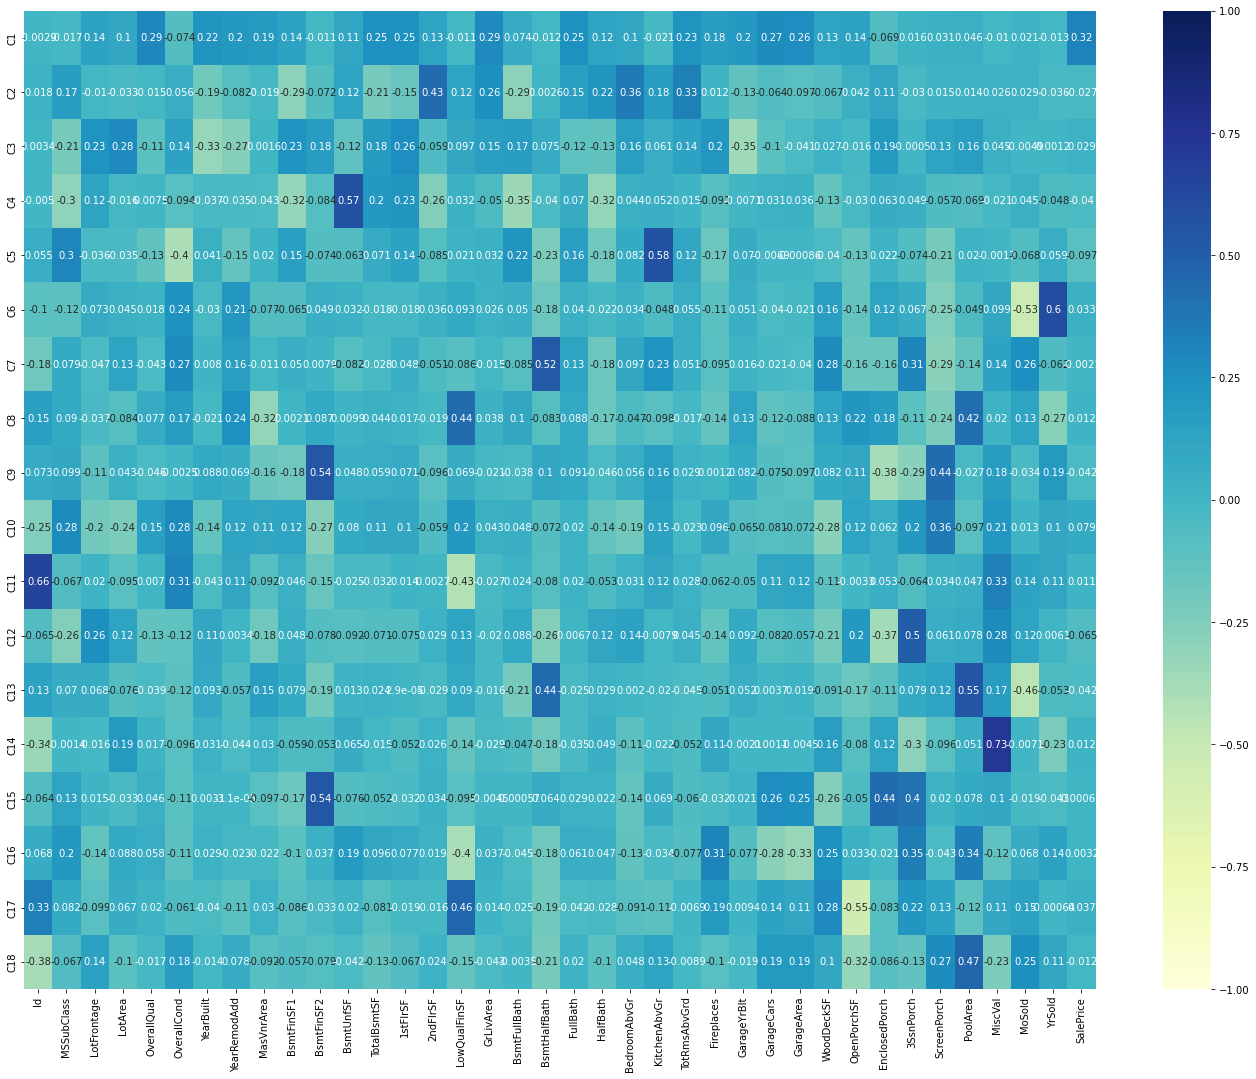

In [40]:
plt.figure(figsize=(24,18))
#relacion de correlacion entre los componentes del DF
sns.heatmap(df_pca_comp, vmin=-1, vmax=1,cmap='YlGnBu',annot=True)

### Quedaria continuando este proceso, me gustaria aplicar algun modelos con los coeficientes obtenidos de PCA